# TAs:
Install Keras-Adversarial library

https://github.com/bstriner/keras-adversarial#installation

Also, use Keras 2.1.2

In [25]:
import matplotlib as mpl
import pandas as pd
import numpy as np
import os
from keras.layers import Reshape, Flatten, LeakyReLU, Activation
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
from keras_adversarial.image_grid_callback import ImageGridCallback
from keras_adversarial import AdversarialModel, simple_gan, gan_targets
from keras_adversarial import normal_latent_sampling, AdversarialOptimizerSimultaneous
from keras_adversarial.legacy import l1l2, Dense, fit
import keras.backend as K

In [26]:
IMAGE_EDGE_SIZE = 50
LATENT_DIM = IMAGE_EDGE_SIZE ** 2
IMAGE_SHAPE = (IMAGE_EDGE_SIZE, IMAGE_EDGE_SIZE)
HIDDEN_DIM = 1024
REGULARIZER = lambda: l1l2(1e-5, 1e-5)
LOSS_FUNCTION = 'binary_crossentropy'
OUTPUT_PATH = "output/gan"
NB_EPOCH = 100

In [27]:
generator_layers = [
        Dense(int(HIDDEN_DIM / 4), name="gen1", input_dim=LATENT_DIM, W_regularizer=REGULARIZER()),
        LeakyReLU(0.2),
        Dense(int(HIDDEN_DIM / 2), name="gen2", W_regularizer=REGULARIZER()),
        LeakyReLU(0.2),
        Dense(HIDDEN_DIM, name="gen3", W_regularizer=REGULARIZER()),
        LeakyReLU(0.2),
        Dense(np.prod(IMAGE_SHAPE), name="genx_flat", W_regularizer=REGULARIZER()),
        Activation('sigmoid'),
        Reshape(IMAGE_SHAPE, name="genx")]

generator = Sequential(generator_layers,
        name="generator")

# generator.summary()

In [28]:
discriminator_layers = [
        Flatten(name="disc1", input_shape=IMAGE_SHAPE),
        Dense(HIDDEN_DIM, name="disc2", W_regularizer=REGULARIZER()),
        LeakyReLU(0.2),
        Dense(int(HIDDEN_DIM / 2), name="disc3", W_regularizer=REGULARIZER()),
        LeakyReLU(0.2),
        Dense(int(HIDDEN_DIM / 4), name="disc4", W_regularizer=REGULARIZER()),
        LeakyReLU(0.2),
        Dense(1, name="discy", W_regularizer=REGULARIZER()),
        Activation("sigmoid")]
              
discriminator = Sequential(discriminator_layers,
        name="discriminator")

# discriminator.summary()

In [29]:
gan = simple_gan(generator, discriminator, normal_latent_sampling((LATENT_DIM,)))
# gan.summary()

In [30]:
adv_optimizer = AdversarialOptimizerSimultaneous()
output_path = "output/gan"
generator_optimizer = Adam(1e-4, decay=1e-4)
discriminator_optimizer = Adam(1e-3, decay=1e-4)

In [31]:
model = AdversarialModel(base_model=gan,
                         player_params=[generator.trainable_weights, discriminator.trainable_weights],
                         player_names=["generator", "discriminator"]
                        )
model.adversarial_compile(adversarial_optimizer=adv_optimizer,
                          player_optimizers=[generator_optimizer, discriminator_optimizer],
                          loss=LOSS_FUNCTION)

In [32]:
# create callback to generate images
zsamples = np.random.normal(size=(10 * 10, LATENT_DIM))

def generator_sampler():
    return generator.predict(zsamples).reshape((10, 10, 28, 28))

generator_cb = ImageGridCallback(os.path.join(OUTPUT_PATH, "epoch-{:03d}.png"), generator_sampler)

In [33]:
# Method that takes a filepath to the folder containing the cyrillic images. Loops through each file, returning
# a dataframe with the image data and classification in a pandas dataframe.

from PIL import Image

def build_images_data(cyrillic_path):
    df = pd.DataFrame()

    for dirName, subdirList, fileNames in os.walk(cyrillic_path):
        for i, fileName in enumerate(fileNames):
            if fileName.endswith(".png"):
    #             print "{n}. {dirName}/{fileName}".format(n=i, dirName=dirName, fileName=fileName)
                img_bitmap = get_image_data(os.path.join(dirName, fileName))
                character = dirName.split("/")[-1]
                df = df.append(pd.DataFrame([[character, img_bitmap]], columns=['classification', 'imageData']), ignore_index=True)
        
    return df

In [34]:
# Method for taking a filepath to the cyrillic png and returning transformed data.
# This method returns a flat array of 0s and 1s, according to whether the image was black or white.
binarizer = np.vectorize(lambda i: 1 if i > 0 else 0)

def get_image_data(filepath):
        img = Image.open(filepath)
        img = img.resize((IMAGE_EDGE_SIZE, IMAGE_EDGE_SIZE), Image.ANTIALIAS)
        bitmap = np.array(img.getdata())
#         bitmap = bitmap[:,3] # only need the fourth item in the RGB (transparency)
#         bitmap = binarizer(bitmap) # change bitmap to 1 or 0
        img.close()
        return bitmap

In [35]:
# train model
cyrillic_path = "../Cyrillic"
        
df = build_images_data(cyrillic_path)
y_data = pd.Categorical(df["classification"]).codes
x_data = list(df["imageData"].values)

In [36]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3)
x_train = np.array(x_train)
x_test = np.array(x_test)
y = gan_targets(x_train.shape[0])
ytest = gan_targets(x_test.shape[0])

UNIQUE_CLASSES = pd.Categorical(df['classification']).unique()
N_CLASSES = len(UNIQUE_CLASSES)

In [37]:
# callbacks = [generator_cb]
callbacks = []

# if K.backend() == "tensorflow":
#     callbacks.append(
#         TensorBoard(log_dir=os.path.join(OUTPUT_PATH, 'logs'), histogram_freq=0, write_graph=True, write_images=True))
history = fit(model, x=x_train, y=y_train, validation_data=(x_test, y_test), callbacks=callbacks, nb_epoch=NB_EPOCH, batch_size=32)

# save models
generator.save(os.path.join(path, "generator.h5"))
discriminator.save(os.path.join(path, "discriminator.h5"))

ValueError: Error when checking input: expected disc1_input to have shape (None, 50, 50) but got array with shape (10836, 2500, 4)

In [4]:
# Put a Cyrillic folder in the same folder as this file
cyrillic_path = "../Cyrillic"
        
df = build_images_data(cyrillic_path)

df.head()

,classification,imageData
0,Б,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Б,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Б,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Б,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Б,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."


In [5]:
y_data = pd.Categorical(df["classification"]).codes
x_data = list(df["imageData"].values)

UNIQUE_CLASSES = pd.Categorical(df['classification']).unique()
N_CLASSES = len(UNIQUE_CLASSES)

# Train Neural Net

In [31]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.3)

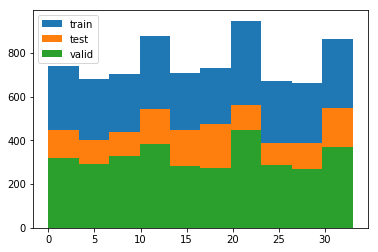

In [32]:
import matplotlib.pyplot as plt

plt.hist(y_train)
plt.hist(y_test)
plt.hist(y_valid)
plt.legend(["train", "test", "valid"])
plt.show()

In [33]:
# Format the y data into an array of 34 items, with 1 for the correct answer

import keras.utils as kutils

y_train = kutils.to_categorical(y_train, num_classes=N_CLASSES, dtype='int8')
y_test  = kutils.to_categorical(y_test,  num_classes=N_CLASSES, dtype='int8')
y_valid = kutils.to_categorical(y_valid, num_classes=N_CLASSES, dtype='int8')

In [42]:
from keras.models import Sequential
from keras.layers import Dense

nn = Sequential()

layers = [
    Dense(units=200, activation='relu', input_dim=IMAGE_EDGE_SIZE**2),
    Dense(units=300, activation='relu'),
    Dense(units=500, activation='relu'),
    Dense(units=300, activation='relu'),
    Dense(units=200, activation='relu'),
    Dense(units=100, activation='relu'),
    Dense(units=50, activation='relu'),
]

for layer in layers:
    nn.add(layer)

OutputLayer = Dense(units=N_CLASSES, activation='softmax')
nn.add(OutputLayer)

nn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 200)               500200    
_________________________________________________________________
dense_34 (Dense)             (None, 300)               60300     
_________________________________________________________________
dense_35 (Dense)             (None, 500)               150500    
_________________________________________________________________
dense_36 (Dense)             (None, 300)               150300    
_________________________________________________________________
dense_37 (Dense)             (None, 200)               60200     
_________________________________________________________________
dense_38 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_39 (Dense)             (None, 50)                5050      
__________

In [35]:
# transform data into format keras likes. This shouldn't be necessary but I'm not sure how to do it beautifully.

def transform(data):
    for i, row in enumerate(data):
        data[i] = np.array(row)
    return data

y_train = transform(y_train)
y_test  = transform(y_test)
y_valid = transform(y_valid)

In [36]:
# Same with x data

x_train = np.array(x_train)
x_test  = np.array(x_test)
x_valid = np.array(x_valid)

In [43]:
nn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
output = nn.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_valid, y_valid))
nn.save_weights("./model")

Train on 7585 samples, validate on 3251 samples
Epoch 1/50
7585/7585 [==============================] - 5s 679us/step - loss: 2.8263 - acc: 0.1877 - val_loss: 2.1679 - val_acc: 0.3294
Epoch 2/50
7585/7585 [==============================] - 4s 559us/step - loss: 1.7344 - acc: 0.4539 - val_loss: 1.6713 - val_acc: 0.4592
Epoch 3/50
7585/7585 [==============================] - 4s 582us/step - loss: 1.3039 - acc: 0.5879 - val_loss: 1.4632 - val_acc: 0.5604
Epoch 4/50
7585/7585 [==============================] - 6s 788us/step - loss: 0.9708 - acc: 0.6924 - val_loss: 1.2167 - val_acc: 0.6456
Epoch 5/50
7585/7585 [==============================] - 5s 683us/step - loss: 0.7168 - acc: 0.7691 - val_loss: 1.2886 - val_acc: 0.6420
Epoch 6/50
7585/7585 [==============================] - 4s 578us/step - loss: 0.6288 - acc: 0.7942 - val_loss: 1.2022 - val_acc: 0.6795
Epoch 7/50
7585/7585 [==============================] - 4s 573us/step - loss: 0.4646 - acc: 0.8471 - val_loss: 1.2403 - val_acc: 0.6730


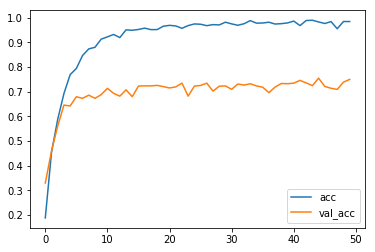

In [44]:
plt.plot(output.history["acc"])
plt.plot(output.history["val_acc"])
plt.legend(["acc", "val_acc"])

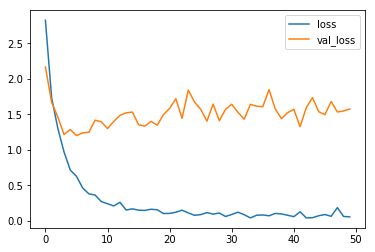

In [45]:
plt.plot(output.history["loss"])
plt.plot(output.history["val_loss"])
plt.legend(["loss", "val_loss"])

In [46]:
results = nn.evaluate(x_test, y_test)
print "Loss: {}".format(results[0])
print "Acc:  {}".format(results[1])

4644/4644 [==============================] - 1s 132us/step
Loss: 1.613257347
Acc:  0.743324720069
